In [11]:
import pandas as pd
import numpy as np

# Project introduction

For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.

# Data Preperation

In [12]:
# generate two data frames containing all of the listing and calendar data for each location
import os
import pandas as pd

directory_path = 'home_rentals/'

# Initialize an empty list to store DataFrames
listing_df = []
calendar_df = []

# Iterate through subdirectories
for subdirectory in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdirectory) 

    csv_listing_file_path = os.path.join(subdirectory_path, "listings.csv.gz")
    csv_calendar_file_path = os.path.join(subdirectory_path, "calendar.csv.gz")
    print(csv_listing_file_path)
    print(csv_calendar_file_path)

    df1 = pd.read_csv(csv_listing_file_path)
    df2 = pd.read_csv(csv_calendar_file_path)

    df1['location'] = subdirectory
    df2['location'] = subdirectory

    listing_df.append(df1)
    calendar_df.append(df2)


# Concatenate all DataFrames into a single DataFrame
all_listing_df = pd.concat(listing_df, ignore_index=True)
all_calendar_df = pd.concat(calendar_df, ignore_index=True)

home_rentals/Amsterdam\listings.csv.gz
home_rentals/Amsterdam\calendar.csv.gz
home_rentals/Barcelona\listings.csv.gz
home_rentals/Barcelona\calendar.csv.gz
home_rentals/Euskadi\listings.csv.gz
home_rentals/Euskadi\calendar.csv.gz
home_rentals/Geneva\listings.csv.gz
home_rentals/Geneva\calendar.csv.gz
home_rentals/Ireland\listings.csv.gz
home_rentals/Ireland\calendar.csv.gz
home_rentals/Lisbon\listings.csv.gz
home_rentals/Lisbon\calendar.csv.gz
home_rentals/Los Angeles\listings.csv.gz
home_rentals/Los Angeles\calendar.csv.gz
home_rentals/Madrid\listings.csv.gz
home_rentals/Madrid\calendar.csv.gz
home_rentals/Malaga\listings.csv.gz
home_rentals/Malaga\calendar.csv.gz
home_rentals/Mallorca\listings.csv.gz
home_rentals/Mallorca\calendar.csv.gz
home_rentals/Malta\listings.csv.gz
home_rentals/Malta\calendar.csv.gz
home_rentals/Menorca\listings.csv.gz
home_rentals/Menorca\calendar.csv.gz
home_rentals/Mexico City\listings.csv.gz
home_rentals/Mexico City\calendar.csv.gz
home_rentals/Milan\listi

In [13]:
all_calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,2818,2022-09-07,f,$49.00,$49.00,3.0,1125.0,Amsterdam
1,2818,2022-09-08,f,$49.00,$49.00,3.0,1125.0,Amsterdam
2,2818,2022-09-09,f,$49.00,$49.00,3.0,1125.0,Amsterdam
3,2818,2022-09-10,f,$49.00,$49.00,3.0,1125.0,Amsterdam
4,2818,2022-09-11,f,$49.00,$49.00,3.0,1125.0,Amsterdam
...,...,...,...,...,...,...,...,...
124889345,2869130,2023-09-18,t,$575.00,$575.00,27.0,57.0,Zurich
124889346,2869130,2023-09-19,t,$575.00,$575.00,27.0,57.0,Zurich
124889347,2869130,2023-09-20,t,$575.00,$575.00,27.0,57.0,Zurich
124889348,2869130,2023-09-21,t,$575.00,$575.00,27.0,57.0,Zurich


In [14]:
all_listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Removing Irrelevant columns 

Since this dataset has a lot of variables, we can start by removing colums that will be clearly irrelevant for our research question such as the following:

- *'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', host_url', 'host_name'*  = Identifier variables
-  *'name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text'*  = We will not be working with textual data for this analysis, for the sake of efficiency and time
- *'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude', region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name'* = We will only be using Country in our analysis as a geographic identifier, in order to reduce the dimension of our data while keeping some identifiabiltiy (since there are 20 countries)
- *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'* = These are variables that will be dependant on our predictor variable in this analysis 

In [1]:
columns_drop = ['scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', 'host_url','name', 
                    'description', 'neighborhood_overview', 'host_about', 'bathrooms_text', 'neighbourhood',
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude',
                    'region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name',
                      'has_availability', 'availability_60', 'availability_90', 
                      
                      'host_id','host_url', 'host_name', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                      'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
                      'host_neighbourhood', 'host_listings_count',
                      'host_total_listings_count', 'host_verifications',
                      'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count',
                      'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms',
                      'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'listing_url', 'accommodates',
                      'amenities', 'minimum_minimum_nights', 'maximum_minimum_nights',
                      'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                      'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
                      'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'requires_license', 
                      'instant_bookable', 'last_searched', 'region_id', 'listings.csv']

all_listing_df_1 = all_listing_df.drop(columns=columns_drop) 

NameError: name 'all_listing_df' is not defined

### Remove rows and columns that have significant amount of NAN values 
 

In [16]:
all_listing_df_1


,id,property_type,room_type,bathrooms,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,NaN,3.0,28.0,NaN,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,NaN,1.0,365.0,NaN,0.0,0.0,Amsterdam
2,2.788600e+04,Private room in houseboat,Private room,NaN,2.0,356.0,NaN,0.0,121.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,NaN,2.0,1825.0,NaN,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,NaN,2.0,730.0,NaN,0.0,160.0,Amsterdam
...,...,...,...,...,...,...,...,...,...,...
342231,5.295024e+07,Entire rental unit,Entire home/apt,NaN,6.0,1125.0,NaN,1.0,1.0,Zurich
342232,5.721959e+17,Entire serviced apartment,Entire home/apt,NaN,3.0,90.0,NaN,0.0,0.0,Zurich
342233,4.607863e+07,Room in hotel,Private room,NaN,1.0,1125.0,NaN,0.0,0.0,Zurich
342234,4.647998e+07,Room in hotel,Private room,NaN,9.0,1125.0,NaN,0.0,0.0,Zurich


In [17]:
#remove all columnns with more than 50% of NaN values 
all_listing_df_2 = all_listing_df_1.dropna(thresh=0.5*len(all_listing_df_1), axis=1)
all_listing_df_2

,id,property_type,room_type,minimum_nights,maximum_nights,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,3.0,28.0,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,1.0,365.0,0.0,0.0,Amsterdam
2,2.788600e+04,Private room in houseboat,Private room,2.0,356.0,0.0,121.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2.0,1825.0,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,2.0,730.0,0.0,160.0,Amsterdam
...,...,...,...,...,...,...,...,...
342231,5.295024e+07,Entire rental unit,Entire home/apt,6.0,1125.0,1.0,1.0,Zurich
342232,5.721959e+17,Entire serviced apartment,Entire home/apt,3.0,90.0,0.0,0.0,Zurich
342233,4.607863e+07,Room in hotel,Private room,1.0,1125.0,0.0,0.0,Zurich
342234,4.647998e+07,Room in hotel,Private room,9.0,1125.0,0.0,0.0,Zurich


In [18]:
removed_columns=[col for col in all_listing_df_1 if col not in all_listing_df_2]

print(f'the columns removed are {removed_columns}')

the columns removed are ['bathrooms', 'calendar_updated']


In [19]:
#After removing all the columns with more than 50% of NaN values we are now going to look at rows and remove those too
threshold = 0.70 
all_listing_df_3 = all_listing_df_2.dropna(thresh=float(threshold * len(all_listing_df_2.columns)))
removed_rows = len(all_listing_df_2) - len(all_listing_df_3)
print(f'num of removed rows is {removed_rows}')

all_listing_df_3

num of removed rows is 1


,id,property_type,room_type,minimum_nights,maximum_nights,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,3.0,28.0,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,1.0,365.0,0.0,0.0,Amsterdam
2,2.788600e+04,Private room in houseboat,Private room,2.0,356.0,0.0,121.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2.0,1825.0,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,2.0,730.0,0.0,160.0,Amsterdam
...,...,...,...,...,...,...,...,...
342231,5.295024e+07,Entire rental unit,Entire home/apt,6.0,1125.0,1.0,1.0,Zurich
342232,5.721959e+17,Entire serviced apartment,Entire home/apt,3.0,90.0,0.0,0.0,Zurich
342233,4.607863e+07,Room in hotel,Private room,1.0,1125.0,0.0,0.0,Zurich
342234,4.647998e+07,Room in hotel,Private room,9.0,1125.0,0.0,0.0,Zurich


In [20]:
all_listing_df_3["room_type"].value_counts()

room_type
Entire home/apt    244135
Private room        91261
Shared room          3788
Hotel room           3051
Name: count, dtype: int64

In [21]:
# remove hotel rooms since they are irrelevant to our investors 
all_listing_df_4 = all_listing_df_3[all_listing_df_3['room_type'] != 'Hotel room']
all_listing_df_4["room_type"].value_counts()


room_type
Entire home/apt    244135
Private room        91261
Shared room          3788
Name: count, dtype: int64

In [22]:
all_listing_df_4["property_type"].value_counts()


property_type
Entire rental unit             121893
Entire home                     36243
Private room in rental unit     34444
Entire condo                    33638
Private room in home            21393
                                ...  
Shared room in tower                1
Shared room in train                1
Private room in ice dome            1
Private room in ranch               1
Shared room in ice dome             1
Name: count, Length: 150, dtype: int64

In [23]:
search_terms = ["Private room", "Shared room", "Entire", "home"]
# Create a new DataFrame by filtering out rows containing search terms
filtered_df = all_listing_df_4[~all_listing_df_4['property_type'].str.contains(
    '|'.join(search_terms))]

# Display the filtered DataFrame
print(len(filtered_df))
print(filtered_df['property_type'].value_counts())

9610
property_type
Room in hotel             3129
Room in boutique hotel    3066
Room in aparthotel         903
Camper/RV                  601
Boat                       448
Farm stay                  394
Houseboat                  178
Casa particular            149
Barn                       118
Hut                        100
Campsite                    78
Castle                      68
Tent                        64
Treehouse                   36
Yurt                        35
Dome                        32
Windmill                    24
Floor                       23
Shipping container          22
Bus                         21
Shepherd’s hut              21
Holiday park                18
Island                      18
Tipi                        13
Cave                        11
Tower                        9
Ranch                        8
Lighthouse                   6
Room in heritage hotel       5
Religious building           4
Train                        4
Ice dome            

After removing hotels we found that there are "Rooms in Hotel" etc so we had to remove those as well

In [24]:
check_hotel_listed_as_private_room_df = all_listing_df_4[all_listing_df_4["property_type"] == "Room in hotel"]

check_hotel_listed_as_private_room_df["room_type"].value_counts()

room_type
Private room       3126
Entire home/apt       3
Name: count, dtype: int64

In [25]:
filtered_property_types = filtered_df['property_type'].unique()

# Filter out rows in all_listing_df_4 where 'property_type' matches any in filtered_property_types
all_listing_df_5 = all_listing_df_4[~all_listing_df_4['property_type'].isin(
    filtered_property_types)]

# Display the resulting DataFrame
removed_rows = len(all_listing_df_4) - len(all_listing_df_5)
removed_property_types = len(
    all_listing_df_4['property_type'].unique()) - len(all_listing_df_5['property_type'].unique())

print(f'num of removed rows is {removed_rows}')
print(f'number of property types removed {removed_property_types}')

all_listing_df_5

num of removed rows is 9610
number of property types removed 34


,id,property_type,room_type,minimum_nights,maximum_nights,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,3.0,28.0,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,1.0,365.0,0.0,0.0,Amsterdam
2,2.788600e+04,Private room in houseboat,Private room,2.0,356.0,0.0,121.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2.0,1825.0,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,2.0,730.0,0.0,160.0,Amsterdam
...,...,...,...,...,...,...,...,...
342225,6.555674e+17,Private room in rental unit,Private room,1.0,365.0,0.0,0.0,Zurich
342226,3.820260e+07,Entire rental unit,Entire home/apt,2.0,1125.0,0.0,0.0,Zurich
342227,4.205430e+07,Private room in rental unit,Private room,27.0,1125.0,0.0,0.0,Zurich
342231,5.295024e+07,Entire rental unit,Entire home/apt,6.0,1125.0,1.0,1.0,Zurich


c:\Program Files\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


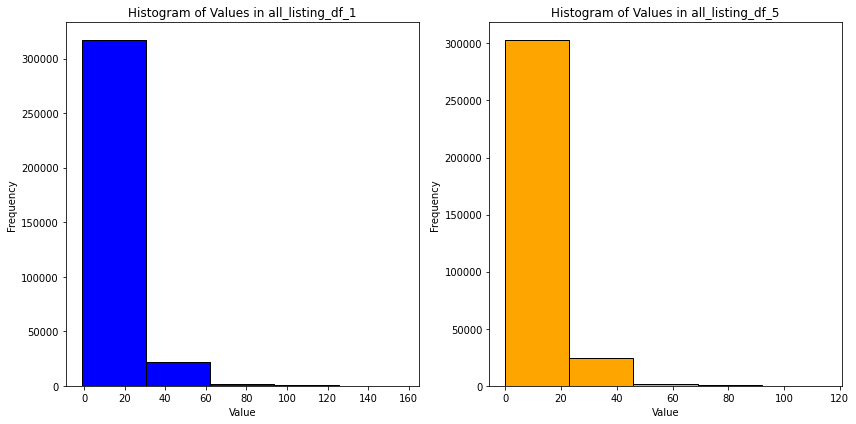

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

temp_df_1 = all_listing_df_1.copy()
temp_df_5 = all_listing_df_5.copy()

# Factorize 'property_type' for temporary DataFrames
temp_df_1['property_type'] = pd.factorize(temp_df_1['property_type'])[0]
temp_df_5['property_type'] = pd.factorize(temp_df_5['property_type'])[0]

plt.figure(figsize=(12, 6))

# Plot the histogram of 'property_type' in all_listing_df_1
plt.subplot(1, 2, 1)
temp_df_1['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_1')

# Plot the histogram of 'property_type' in all_listing_df_5
plt.subplot(1, 2, 2)
temp_df_5['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
all_listing_df_5["room_type"].value_counts()

room_type
Entire home/apt    241127
Private room        84659
Shared room          3788
Name: count, dtype: int64

Now, we are going to check that there are no erros in availability (e.g. that no property is available for more than 30 days per month)

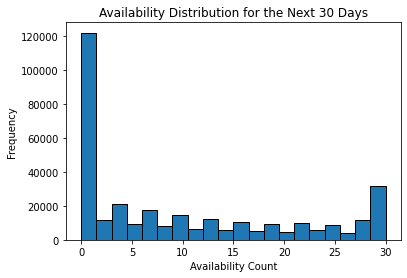

In [28]:
import matplotlib.pyplot as plt

plt.hist(all_listing_df_5["availability_30"], bins=20, edgecolor='black')  
plt.title("Availability Distribution for the Next 30 Days")
plt.xlabel("Availability Count")
plt.ylabel("Frequency")
plt.show()


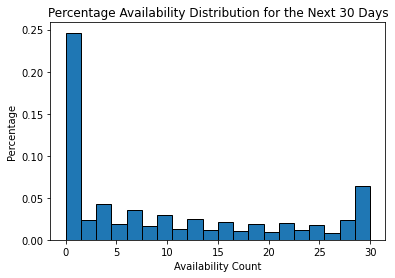

In [29]:
import matplotlib.pyplot as plt

# Assuming all_listing_df_5 is your DataFrame
plt.hist(all_listing_df_5["availability_30"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage Availability Distribution for the Next 30 Days")
plt.xlabel("Availability Count")
plt.ylabel("Percentage")
plt.show()


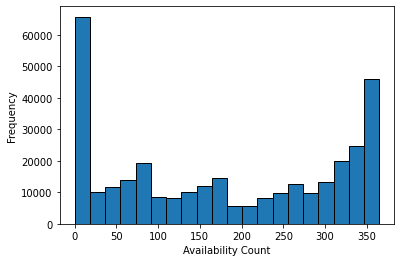

In [30]:
import matplotlib.pyplot as plt
plt.hist(all_listing_df_5["availability_365"], bins=20, edgecolor='black')  
plt.xlabel("Availability Count")
plt.ylabel("Frequency")
plt.show()


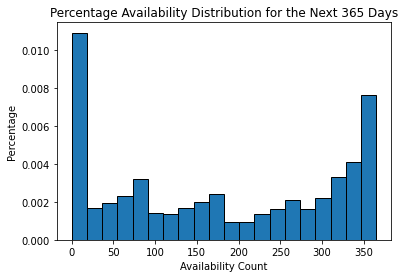

In [31]:
import matplotlib.pyplot as plt

# Assuming all_listing_df_5 is your DataFrame
plt.hist(all_listing_df_5["availability_365"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage Availability Distribution for the Next 365 Days")
plt.xlabel("Availability Count")
plt.ylabel("Percentage")
plt.show()


Since we focus on properties that are going to be rented out for short term stays (targeting tourists) we will now look at the minimum_nights column, and remove all properties that have a high requested minimum_nights (since these would be long term stays)

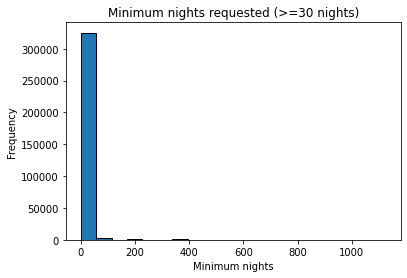

In [32]:
import matplotlib.pyplot as plt

plt.hist(all_listing_df_5["minimum_nights"], bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title("Minimum nights requested (>=30 nights)")
plt.xlabel("Minimum nights")
plt.ylabel("Frequency")
plt.show()

##we can see that there are minimum nights close to 400 nights


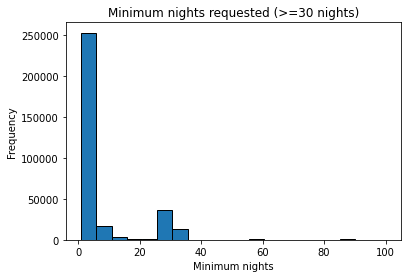

In [33]:
import matplotlib.pyplot as plt
filtered_df = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 100]

plt.hist(filtered_df["minimum_nights"], bins=20, edgecolor='black') 
plt.title("Minimum nights requested (>=30 nights)")
plt.xlabel("Minimum nights")
plt.ylabel("Frequency")
plt.show()


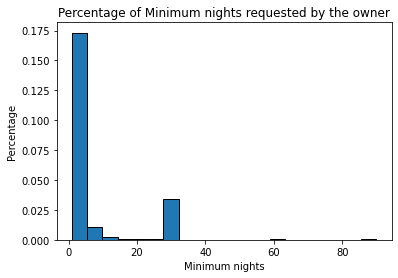

In [34]:
# Assuming all_listing_df_5 is your DataFrame
filtered_df = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 90]
plt.hist(filtered_df["minimum_nights"], bins=20, density=True, edgecolor='black')  # density=True for percentage histogram
plt.title("Percentage of Minimum nights requested by the owner")
plt.xlabel("Minimum nights")
plt.ylabel("Percentage")
plt.show()

In [39]:
# Assuming all_listing_df_5 is your DataFrame

all_listing_df_5["minimum_nights"] = all_listing_df_5["minimum_nights"].astype(int)

counts = all_listing_df_5["minimum_nights"].value_counts(bins=range(0, max(all_listing_df_5["minimum_nights"]) + 31, 30))

# Calculate the percentage column
percentage_column = (counts / len(all_listing_df_5)) * 100

# Create a new DataFrame with counts and percentage_column
result_df = pd.DataFrame({'Counts': counts, 'Percentage': percentage_column})

# Print or display the result DataFrame
print(result_df)


                  Counts  Percentage
(-0.001, 30.0]    311353   94.471348
(30.0, 60.0]       14718    4.465765
(60.0, 90.0]        1364    0.413868
(90.0, 120.0]        532    0.161421
(150.0, 180.0]       499    0.151408
(360.0, 390.0]       474    0.143822
(180.0, 210.0]       125    0.037928
(120.0, 150.0]       118    0.035804
(270.0, 300.0]       110    0.033376
(330.0, 360.0]        77    0.023363
(990.0, 1020.0]       58    0.017598
(480.0, 510.0]        32    0.009710
(1110.0, 1140.0]      26    0.007889
(240.0, 270.0]        24    0.007282
(210.0, 240.0]        23    0.006979
(570.0, 600.0]         7    0.002124
(720.0, 750.0]         6    0.001821
(690.0, 720.0]         6    0.001821
(390.0, 420.0]         6    0.001821
(300.0, 330.0]         6    0.001821
(780.0, 810.0]         4    0.001214
(420.0, 450.0]         2    0.000607
(930.0, 960.0]         1    0.000303
(1080.0, 1110.0]       1    0.000303
(450.0, 480.0]         1    0.000303
(870.0, 900.0]         1    0.000303
(

C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\2514485738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_listing_df_5["minimum_nights"] = all_listing_df_5["minimum_nights"].astype(int)


We can see that more than 98% of all properties have requested a minimum stay of below 60. Therefore it makes sense to remove anything with minimum_nights requested above 60.  

In [40]:
# Assuming all_listing_df_5 is your DataFrame
all_listing_df_6 = all_listing_df_5[all_listing_df_5["minimum_nights"] <= 60]

#Display the filtered DataFrame
all_listing_df_6


,id,property_type,room_type,minimum_nights,maximum_nights,availability_30,availability_365,location
0,2.818000e+03,Private room in rental unit,Private room,3,28.0,1.0,14.0,Amsterdam
1,2.016800e+04,Private room in townhouse,Private room,1,365.0,0.0,0.0,Amsterdam
2,2.788600e+04,Private room in houseboat,Private room,2,356.0,0.0,121.0,Amsterdam
3,2.887100e+04,Private room in rental unit,Private room,2,1825.0,4.0,117.0,Amsterdam
4,2.905100e+04,Private room in rental unit,Private room,2,730.0,0.0,160.0,Amsterdam
...,...,...,...,...,...,...,...,...
342225,6.555674e+17,Private room in rental unit,Private room,1,365.0,0.0,0.0,Zurich
342226,3.820260e+07,Entire rental unit,Entire home/apt,2,1125.0,0.0,0.0,Zurich
342227,4.205430e+07,Private room in rental unit,Private room,27,1125.0,0.0,0.0,Zurich
342231,5.295024e+07,Entire rental unit,Entire home/apt,6,1125.0,1.0,1.0,Zurich


In [ ]:
####################### DO ALL OF THE DATA VERIFICATION STUFF HERE ###############################

'''

Target:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.


Part 1: 

TO DO FOR DATA CHECKING + VERIFICATION:
- remove columns that have significant amount of NAN calues
- check that there is no property with number of available days > number of days in each  month 
- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed 


TO DO FOR CONSISTENCY ANALYSIS:
- change dataframe to calculate avalaibilty per month and per location 
- plot average days avaliable for each city
- decide how to allocate consistent vs inconsistent cittes


Part 2:

RUN MODELS: 

Built and Run and test 2 models to try and predict monthly avaliabiltiy 

Model options: NN, linear regression 


'''



#the stuff below is to get the data needed to train the model once the dfs have been cleaned up

"\n\nTarget:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.\n\n\nPart 1: \n\nTO DO FOR DATA CHECKING + VERIFICATION:\n- remove columns that have significant amount of NAN calues\n- check that there is no property with number of available days > number of days in each  month \n- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed \n\n\nTO DO FOR CONSISTENCY ANALYSIS:\n- change dataframe to calculate avalaibilty per month and per location \n- plot average days avaliable for each city\n- decide how to allocate consistent vs inconsistent cittes\n\n\nPart 2:\n\nRUN MODELS: \n\nBuilt and Run and test 2 models to try and predict monthly avaliabiltiy \n\nModel options: NN, linear regression \n\n\n"

## Consistency Analysis

### Creating dataset for average avaliability of listings per month per city

In [37]:

## add code that checks for the id 

def load_rental_data(city_name):
    """
    Load rental data for a specific city from a subdirectory.
    
    Parameters:
    - city_name (str): The name of the city.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    # Construct the directory path based on the city name
    directory_path = f"home_rentals/{city_name}"
    
    # Assuming the file is named 'calendar.csv.gz'
    file_path = f"{directory_path}/calendar.csv.gz"
    
    try:
        # Load the DataFrame from the specified file
        df = pd.read_csv(file_path, compression='gzip')
        
        # You can perform additional processing on the DataFrame if needed
        
        # Return the loaded DataFrame
        return df
    except FileNotFoundError:
        # Handle the case where the file is not found
        print(f"Data not found for {city_name}. Check the directory path and file name.")
        return None
    

def filter_ids(df1, df2):
    """
    Filter out ID values in df1 that are not available in df2.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame.
    - df2 (pd.DataFrame): The second DataFrame.
    - id_column (str): The column containing the ID values.

    Returns:
    - pd.DataFrame: The filtered DataFrame.
    """
    id_column = "id"
    filtered_df = df1[df1["listing_id"].isin(df2["id"])]
    return filtered_df



def averageavaliability(city, latest_df):

    cityname = city
    citydata = load_rental_data(cityname) 

    #filter our ID's that are NOT present in our cleaned all_listings 

    filtered_citydata = filter_ids(citydata, latest_df)
    
    filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
    filtered_citydata["month"] = filtered_citydata["date"].dt.month
    filtered_citydata["year"] = filtered_citydata["date"].dt.year
    filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)

    # make a new data frame
    ave_month = (filtered_citydata[filtered_citydata['available'] == 't'].groupby(['listing_id', 'month_year']).size().unstack(fill_value=0).stack().reset_index(name='days_available'))
    
    # Calculate the average days_available for each month_year (making sure that it rounds to full numbers)
    ave_month = (ave_month.groupby('month_year')['days_available'].mean().round(0).reset_index(name='average_days_available'))
    # convert the month_year column to datetime format 
    ave_month['month_year'] = pd.to_datetime(ave_month['month_year'], format='%m-%Y').dt.to_period('M')

    # sort the rows by ascending dates
    ave_month = ave_month.sort_values('month_year')

    # reset the row index
    ave_month.reset_index(drop=True, inplace=True)

    ave_month['location'] = city

    return ave_month




In [38]:
# Will take 10 mins to run but it WORKSSSSSS SLAY

all_locations = all_listing_df_6["location"].unique()

average_by_month = pd.DataFrame()

for location in all_locations:
    ave_month = averageavaliability(location, all_listing_df_6)
    average_by_month = pd.concat([average_by_month, ave_month], axis=0)
    print(location)


    

C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Amsterdam


C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Barcelona


C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Euskadi


C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Geneva


C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Ireland


C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Lisbon


C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_citydata["month"] = filtered_citydata["date"].dt.month
C:\Users\elisa\AppData\Local\Temp\ipykernel_20360\3489930091.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

KeyboardInterrupt: 

In [ ]:
# note that all of the properties in Madrid have no listing ID in the listings data file. Thus, we cannot merge the calendar and the listings
# data for the city because we do not have the corresponding IDs. As such, the function removed all of the Madrid properties. 

average_by_month["location"].unique()

array(['Zurich', 'Barcelona', 'Milan', 'Valencia', 'Mallorca',
       'Washington', 'Rotterdam', 'Tokyo', 'Los Angeles', 'Lisbon',
       'Ireland', 'Mexico City', 'Geneva', 'Euskadi', 'Vienna',
       'Vancouver', 'San Diego', 'Menorca', 'Naples', 'Toronto',
       'San Francisco', 'Winnipeg', 'Rome', 'Malta', 'Amsterdam',
       'Malaga'], dtype=object)

### Correcting for additional months

In [ ]:
# check for the unique "month_year" vaues in the average_by_month dataframe. This allows us to see what months are covered by the data
average_by_month["month_year"].unique()


<PeriodArray>
['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10']
Length: 14, dtype: period[M]

In [ ]:
# All of the locations should have data from 2022-09 until 2023-09. From above, we see that some locations also have 2023-10
# loop through the dataframe and remove observations in 2023-10 for any locations that may have them

# Create a boolean mask based on the specified conditions
mask = average_by_month['month_year'] == "2023-10"

# Use the boolean mask to filter the DataFrame and keep only the rows that don't match the conditions
average_by_month = average_by_month[~mask]

# check that we got the result we wanted
average_by_month["month_year"].value_counts()



2022-09    26
2022-10    26
2022-11    26
2022-12    26
2023-01    26
2023-02    26
2023-03    26
2023-04    26
2023-05    26
2023-06    26
2023-07    26
2023-08    26
2023-09    26
Freq: M, Name: month_year, dtype: int64

As can be seen above, all of the locations have data ranging from 2022-09 to 2023-09, except for Euskadi which has an extra month of data (2023-10). This is an additional month in comparison to the other locations, as such we will remove it to have a consistent range of data between all of the locations.


Next, we will look at the seasonality of each month for each location, comparing it between the locations and calculating a seasonality index. We do this so as to have an idea of how consistent the bookings are per month for each location.

In [ ]:
# Calculate the seasonality index for each month of each location

# find the average availability per month between all locations
seasonality_df = average_by_month
seasonality_df['Average'] = seasonality_df.groupby('month_year')['average_days_available'].transform('mean')

# calculate the seasonality index for each location's month and append it to the dataframe 
seasonality_df['Seasonality_Index_%'] = round((seasonality_df['average_days_available'] / seasonality_df['Average']) * 100,1)

# remove the Average column since it is no longer needed
#seasonality_df = seasonality_df.drop("Average", axis=1)

# show the data frame 
seasonality_df




,month_year,average_days_available,location,Average,Seasonality_Index_%
0,2022-09,3.0,Amsterdam,3.884615,77.2
1,2022-10,7.0,Amsterdam,14.769231,47.4
2,2022-11,11.0,Amsterdam,18.769231,58.6
3,2022-12,11.0,Amsterdam,19.192308,57.3
4,2023-01,13.0,Amsterdam,19.384615,67.1
...,...,...,...,...,...
8,2023-05,16.0,Zurich,17.000000,94.1
9,2023-06,16.0,Zurich,15.846154,101.0
10,2023-07,16.0,Zurich,15.846154,101.0
11,2023-08,17.0,Zurich,16.038462,106.0


The seasonality index indicates how the availability per month of each location varies with respect to a seasonal pattern. A seasonality index value above 100% indicates a period of higher demand or availability compared to the average. A seasonality index value below 100%, instead, indicates a period of lower demand or availability compared to the average. Finally, a seasonality index of 100% suggests that the availability is in line with the average, without any significant seasonal deviation.

In order to visualise the above results better, we will generate a bar graph for each location showing the average days available and the seasonality of each month in the location. In this way, we can get a better idea of the actual days of availability per month in each location, and how this value compares with other locations (we see this via the seasonality index).

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


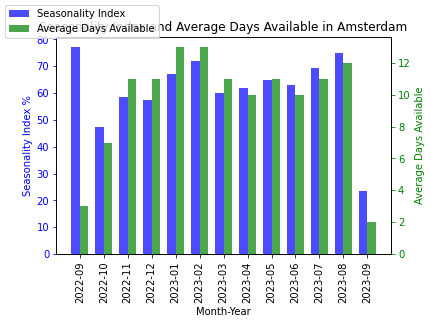

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


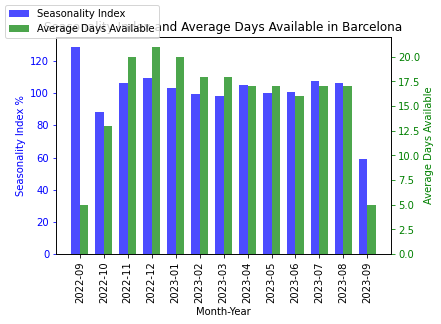

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


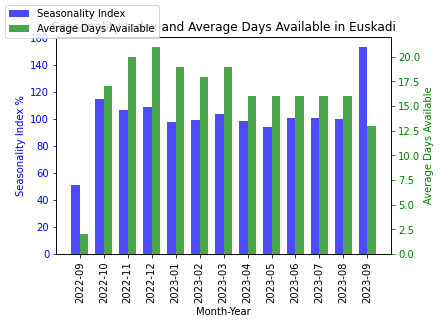

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


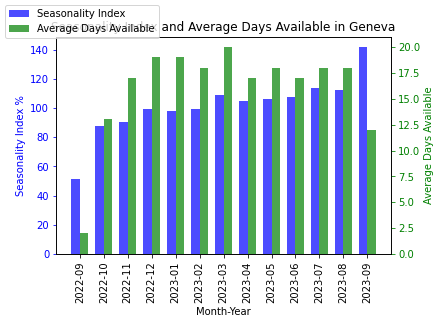

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


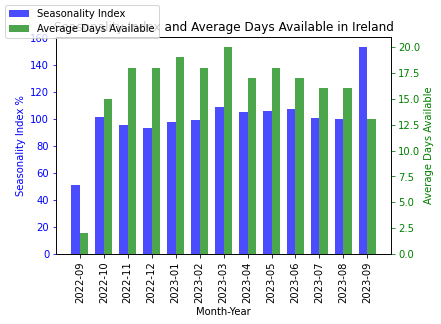

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


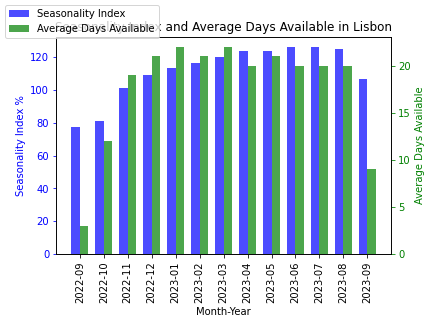

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


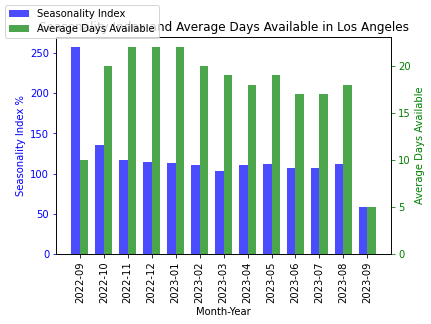

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


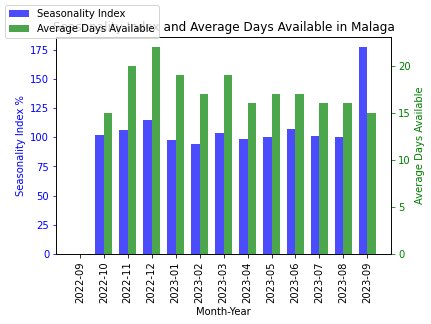

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


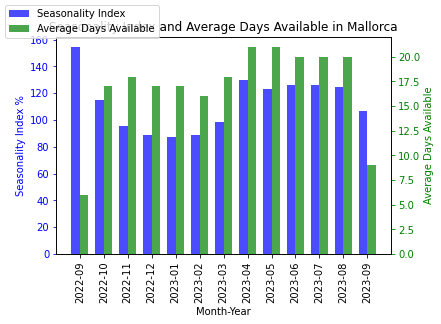

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


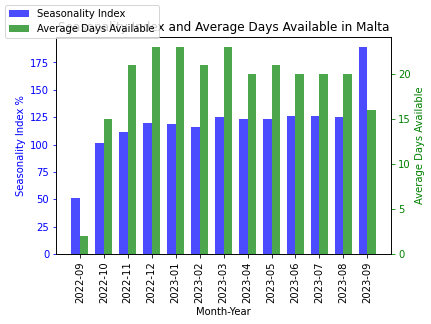

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


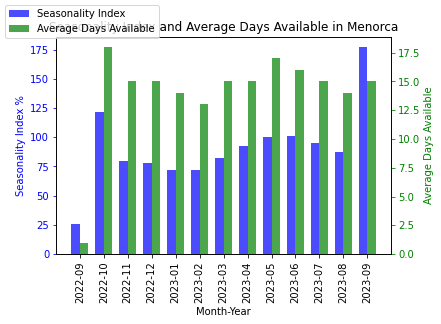

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


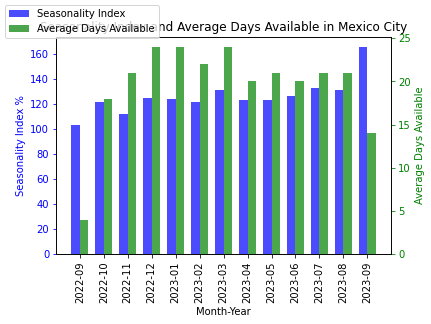

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


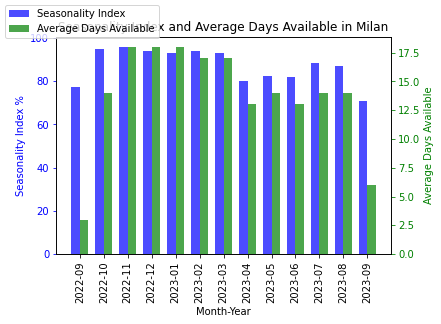

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


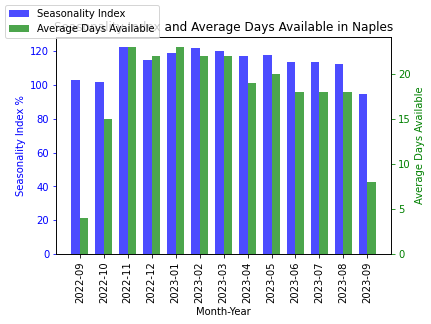

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


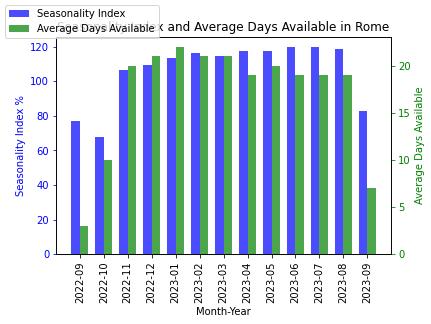

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


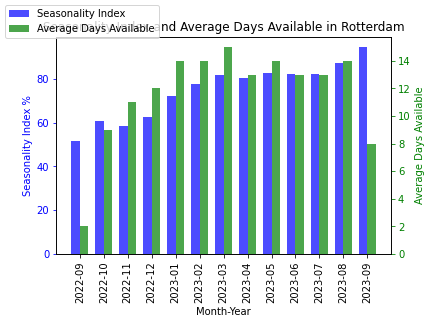

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


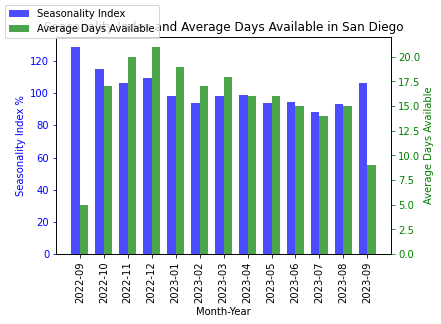

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


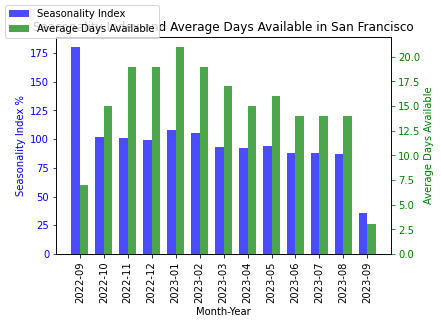

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


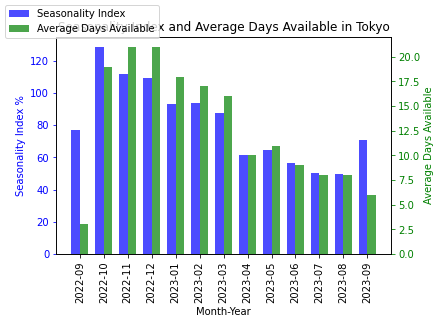

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


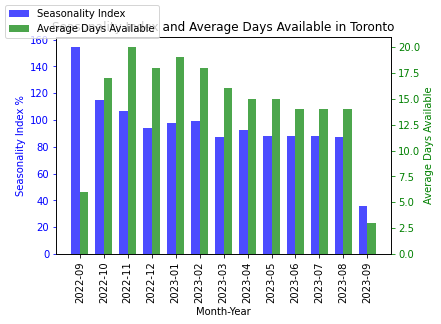

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


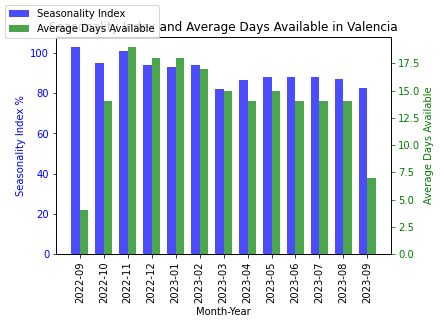

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


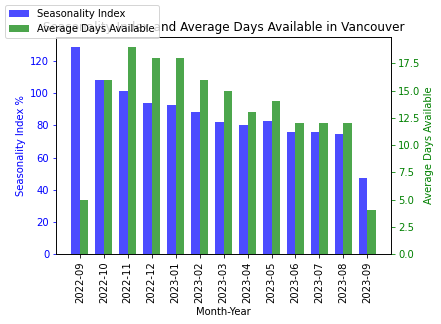

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


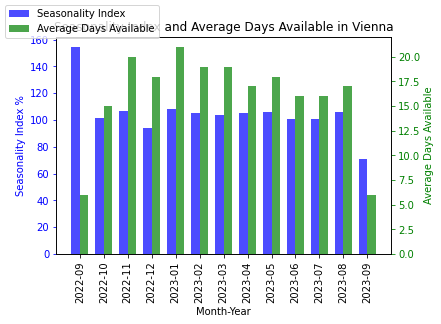

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


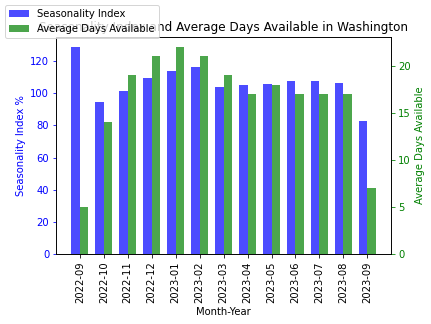

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


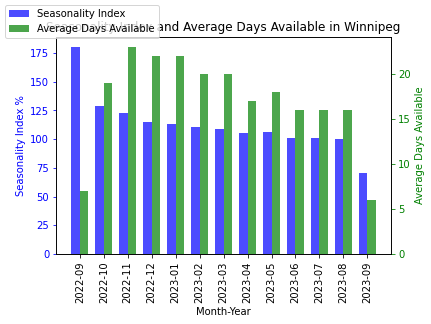

C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_given_location['month_year'] = season_given_location['month_year'].astype(str)
C:\Users\elisa\AppData\Local\Temp\ipykernel_25476\3464662411.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_name['month_year'] = location_name['month_year'].astype(str)


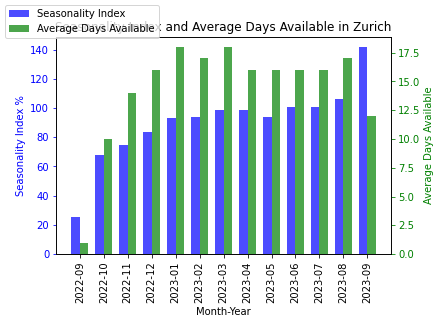

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the monthly availability and seasonality index for each location

all_the_locations = average_by_month["location"].unique()

# Set the width of the bars
bar_width = 0.35

# Make the bar charts
for location in all_the_locations:

    season_given_location = seasonality_df[seasonality_df["location"] == location]
    location_name = average_by_month[average_by_month['location'] == location]

    av_si = season_given_location['Seasonality_Index_%']
    av_availability = location_name['average_days_available']

    season_given_location['month_year'] = season_given_location['month_year'].astype(str)
    location_name['month_year'] = location_name['month_year'].astype(str)

    # Create a figure and primary y-axis
    fig, ax1 = plt.subplots()

    # Plot Seasonality Index on the primary y-axis
    ax1.bar(np.arange(len(season_given_location['month_year'])), av_si, width=bar_width, color='blue', alpha=0.7, label='Seasonality Index')
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel('Seasonality Index %', color='blue')
    ax1.tick_params('y', colors='blue')
    ax1.set_title(f'Seasonality Index and Average Days Available in {location}')

    # Create a twin Axes sharing the x-axis
    ax2 = ax1.twinx()

    # Plot Average Days Available on the secondary y-axis
    ax2.bar(np.arange(len(location_name['month_year'])) + bar_width, av_availability, width=bar_width, color='green', alpha=0.7, label='Average Days Available')
    ax2.set_ylabel('Average Days Available', color='green')
    ax2.tick_params('y', colors='green')

    # Set x-axis ticks and labels
    ax1.set_xticks(np.arange(len(season_given_location['month_year'])) + bar_width / 2)
    ax1.set_xticklabels(season_given_location['month_year'], rotation=90)

    # Display the legend
    fig.legend(loc='upper left')

    # Show the plot
    plt.show()


The graphs above allow us to gain a better understanding of the distribution of our data, however there is too much data (and thus it is too specific) for it to be useful when building models. As such, we will calculate a single seasonality index for each location. 

In [ ]:
# Calculate the seasonality index for each location

# find the average availability for each locations
seasonality_per_location_df = pd.DataFrame()

seasonality_per_location_df["location"] = average_by_month["location"].unique()

# calculate one average availability per location
for location in all_locations:
    average_avail_per_loc_df = average_by_month.groupby('location')['average_days_available'].mean().reset_index()

# add the average availability of each location to the data frame:
seasonality_per_location_df["average_availability"] = average_avail_per_loc_df["average_days_available"]

# calculate the average availabiity between all locations
average_availbility = average_avail_per_loc_df["average_days_available"].mean()

# calculate the seasonality index for each location and append it to the dataframe 
seasonality_per_location_df['Seasonality_Index_%'] = round((seasonality_per_location_df["average_availability"] / average_availbility) * 100,1)

# show the data frame 
seasonality_per_location_df


,location,average_availability,Seasonality_Index_%
0,Amsterdam,9.615385,62.0
1,Barcelona,15.692308,101.1
2,Euskadi,16.076923,103.6
3,Geneva,16.000000,103.1
4,Ireland,15.923077,102.6
5,Lisbon,17.692308,114.0
6,Los Angeles,17.615385,113.5
7,Malaga,16.076923,103.6
8,Mallorca,16.923077,109.0
9,Malta,18.846154,121.4


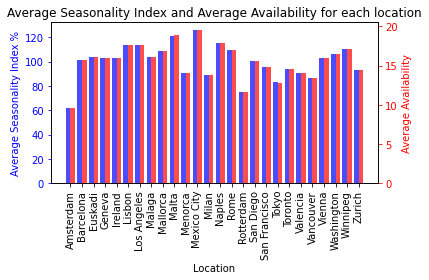

In [ ]:
# let's plot the seasonality index and average availability of all locations on one graph:

import matplotlib.pyplot as plt
import numpy as np

# make the bar chart
fig, ax1 = plt.subplots()
bar_width = 0.4
indices = np.arange(len(seasonality_per_location_df['location']))

# plot first axis
ax1.bar(indices - bar_width / 2, seasonality_per_location_df['Seasonality_Index_%'], color='b', alpha=0.7, label='Average Seasonality Index %', width=bar_width)
ax1.set_xlabel('Location')
ax1.set_ylabel('Average Seasonality Index %', color='b')
ax1.set_xticks(indices)
ax1.set_xticklabels(seasonality_per_location_df['location'], rotation=90)  # Rotate x-axis labels vertically
ax1.tick_params('y', colors='b')

# Twin axis for Average Availability on the right axis
ax2 = ax1.twinx()
# Adjust the x-coordinates for the second set of bars
ax2.bar(indices + bar_width / 2, seasonality_per_location_df['average_availability'], color='r', alpha=0.7, label='Average Availability', width=bar_width)
ax2.set_ylabel('Average Availability', color='r')
ax2.tick_params('y', colors='r')

# Title and legend
plt.title('Average Seasonality Index and Average Availability for each location')
fig.tight_layout()
plt.show()

As expected, the average seasonality index and the average availability distributions exactly match each other. This is because, to calculate the seasonality, we are simply taking the average availability of the location and multiplying it by a constant (100 / average availability of data set). 

Although the seasonality index gives us a good insight of the general distribution of availabilities of locations, we have determined that it is superfluous in the context of building our models. This is because the objective of the model is to tell an investor where the best location to buy a property destined to be rented out on Airbnb would be, and thus the investor is not interested in the monthly seasonality of the location, but rather the yearly one (since the property is to be rented out for the whole year). However, since the yearly seasonality index is matched by the average availability of the property, it is easier to simply look at the average availability of the locations and discard the seasonality index. 

## Pricing Analysis

*Add Gabriel's code here*

# Model generation

## Linear regression

## KNN